
# Getting Starting using TVMC Python: a high-level API for TVM
**Author**:
[Jocelyn Shiue](https://github.com/CircleSpin)

Hi! Here we explain the scripting tool designed for the complete TVM beginner. 🙂

Before we get started let's get an example model if you don't already have one.
Follow the steps to download a resnet model via the terminal:

```python
mkdir myscripts
cd myscripts
wget https://github.com/onnx/models/raw/b9a54e89508f101a1611cd64f4ef56b9cb62c7cf/vision/classification/resnet/model/resnet50-v2-7.onnx
mv resnet50-v2-7.onnx my_model.onnx
touch tvmcpythonintro.py
```
Let's start editing the python file in your favorite text editor.


## Step 0: Imports

```python
from tvm.driver import tvmc
```


In [2]:
from tvm.driver import tvmc

## Step 1: Load a model

Let's import our model into tvmc. This step converts a machine learning model from
a supported framework into TVM's high level graph representation language called Relay.
This is to have a unified starting point for all models in tvm. The frameworks we currently
support are: Keras, ONNX, Tensorflow, TFLite, and PyTorch.

```python
model = tvmc.load('my_model.onnx') #Step 1: Load
```
If you'd like to see the Relay, you can run:
``model.summary()``

All frameworks support overwriting the input shapes with a shape_dict argument.
For most frameworks this is optional, but for Pytorch this is necessary as
TVM cannot automatically search for it.

```python
#model = tvmc.load('my_model.onnx', shape_dict={'input1' : [1, 2, 3, 4], 'input2' : [1, 2, 3, 4]}) #Step 1: Load + shape_dict
```
A suggested way to see the model's input/shape_dict is via [netron](https://netron.app/). After opening the model,
click the first node to see the name(s) and shape(s) in the inputs section.

### vision transformer from facebook research
- https://github.com/facebookresearch/dino?tab=readme-ov-file

### from netron.app
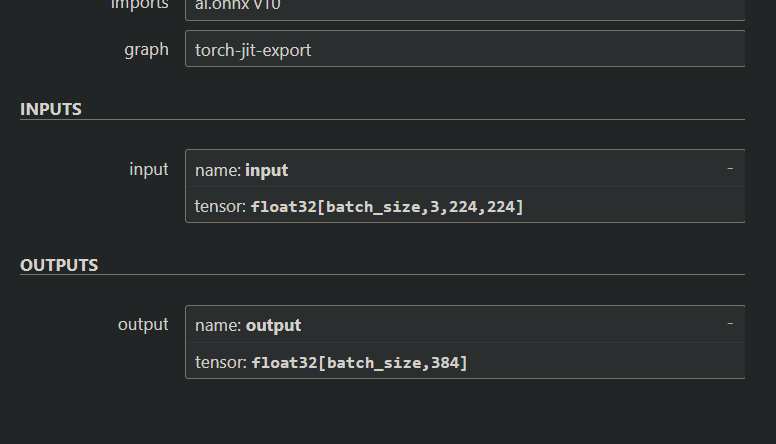

In [4]:
#model = tvmc.load('resnet50-v2-7.onnx')
shape_dict = {'onnx::MatMul_0': (1,2048,2048), 'onnx::MatMul_1': (1,2048,2048)}

model = tvmc.load('onnx_models/matmul_bmm_2048.onnx', shape_dict=shape_dict)
model.summary()

def @main(%onnx::MatMul_0: Tensor[(1, 2048, 2048), float32] /* ty=Tensor[(1, 2048, 2048), float32] span=/MatMul.onnx::MatMul_0:0:0 */, %onnx::MatMul_1: Tensor[(1, 2048, 2048), float32] /* ty=Tensor[(1, 2048, 2048), float32] span=/MatMul.onnx::MatMul_1:0:0 */) -> Tensor[(1, 2048, 2048), float32] {
  %0 = transpose(%onnx::MatMul_1, axes=[0, 2, 1]) /* ty=Tensor[(1, 2048, 2048), float32] span=/MatMul:0:0 */;
  %1 = nn.batch_matmul(%onnx::MatMul_0, %0, out_dtype="float32", transpose_b=True) /* ty=Tensor[(1, 2048, 2048), float32] span=/MatMul:0:0 */;
  reshape(%1, newshape=[1, 2048, 2048]) /* ty=Tensor[(1, 2048, 2048), float32] span=/MatMul:0:0 */
}



## Step 2: Compile

Now that our model is in Relay, our next step is to compile it to a desired
hardware to run on. We refer to this hardware as a target. This compilation process
translates the model from Relay into a lower-level language that the
target machine can understand.

In order to compile a model a tvm.target string is required.
To learn more about tvm.targets and their options look at the [documentation](https://tvm.apache.org/docs/api/python/target.html).
Some examples include:

   1. cuda (Nvidia GPU)
   2. llvm (CPU)
   3. llvm -mcpu=cascadelake (Intel CPU)

```python
package = tvmc.compile(model, target="llvm") #Step 2: Compile
```
The compilation step returns a package.




In [6]:
# package = tvmc.compile(model, target='cuda')
log_file_fb = 'tuning_jsons/matmul_2048.json'

#tvmc.tune(model, target='cuda', enable_autoscheduler=True, tuning_records=log_file_fb)


tvmc.tune(model, target='cuda', enable_autoscheduler=True, prior_records=log_file_fb, tuning_records=log_file_fb)




Get devices for measurement successfully!


KeyboardInterrupt: 

In [7]:
# compilation after tuning see if shared memory usage is not over limit after tuning
package_path = 'cuda_models/matmul_bmm_2048_tuned.tar'

tvmc.compile(model, target='cuda', tuning_records=log_file_fb, package_path=package_path)

new_package = tvmc.TVMCPackage(package_path=package_path)

result = tvmc.run(new_package, device='cuda')

One or more operators have not been tuned. Please tune your model for better performance. Use DEBUG logging level to see more details.


FileNotFoundError: [Errno 2] No such file or directory: 'nvcc'

In [6]:
print(result)

[]
Output Names:
 ['output_0']


### adjusting tiling and IO schedule

```python
import tvm
from tvm import autotvm
from tvm import relay
from tvm.autotvm.tuner import XGBTuner

# Load your model here
# model = ...

# Define the target
target = tvm.target.Target('cuda')

# Extract tasks from the model
tasks = autotvm.task.extract_from_program(model["main"], target=target, params=model["params"])

# Create a tuner
tuner = XGBTuner(tasks)

# Define tuning options
tuning_option = {
    'log_filename': log_file_fb,
    'tuner': 'xgb',
    'n_trial': 1000,
    'early_stopping': 600,
    'measure_option': autotvm.measure_option(
        builder=autotvm.LocalBuilder(timeout=10),
        runner=autotvm.LocalRunner(number=20, repeat=3, timeout=4, min_repeat_ms=150),
    ),
}

# Tune the model
for i, tsk in enumerate(tasks):
    print(f"Tuning task {i+1}/{len(tasks)}: {tsk.name}")
    tuner.tune(tsk, **tuning_option)

# Compile the model with the tuned schedule
with autotvm.apply_history_best(log_file_fb):
    graph, lib, params = relay.build(model, target=target)
```

## Step 3: Run

The compiled package can now be run on the hardware target. The device
input options are: CPU, Cuda, CL, Metal, and Vulkan.

```python
result = tvmc.run(package, device="cpu") #Step 3: Run
```
And you can print the results:
``print(result)``




In [8]:
result = tvmc.run(new_package, device='cuda')

NameError: name 'new_package' is not defined

In [8]:
print(f'result: {result}')

result: []
Output Names:
 ['output_0']


## Step 1.5: Tune [Optional & Recommended]

Run speed can further be improved by tuning. This optional step uses
machine learning to look at each operation within a model (a function) and
tries to find a faster way to run it. We do this through a cost model, and
benchmarking possible schedules.

The target is the same as compile.

```python
tvmc.tune(model, target="llvm") #Step 1.5: Optional Tune
```
The terminal output should look like:

```python
[Task  1/13]  Current/Best:   82.00/ 106.29 GFLOPS | Progress: (48/769) | 18.56 s
[Task  1/13]  Current/Best:   54.47/ 113.50 GFLOPS | Progress: (240/769) | 85.36 s
.....
```
There may be UserWarnings that can be ignored.
This should make the end result faster, but it can take hours to tune.

See the section 'Saving the Tuning Results' below. Be sure to pass the tuning
results into compile if you want the results to apply.

```python
#tvmc.compile(model, target="llvm", tuning_records = "records.log") #Step 2: Compile
```


In [ ]:
#! pip install xgboost

In [ ]:
#tvmc.tune(model, target='llvm')

log_file = 'cuda_tuning.json'

#tvmc.tune(model, target='cuda', enable_autoscheduler=True, tuning_records=log_file)

# tune again
tvmc.tune(model, target='cuda', enable_autoscheduler=True, prior_records=log_file, tuning_records=log_file)

In [ ]:
# tune again if possible some error about 

In [ ]:
# recmpile with the tuned parameters
#tvmc.compile(model, target='llvm', tuning_records='records.log')
tvmc.compile(model, target='cuda', tuning_records=log_file, package_path="cuda_models/resnet50-v2-7-tuned.tar")

new_package = tvmc.TVMCPackage(package_path='cuda_models/resnet50-v2-7-tuned.tar')

result = tvmc.run(new_package, device='cuda')





In [10]:
# save model as json
model.save('tuned_models/matmul_bmm_2048.json')

## Save and then start the process in the terminal:

```python
python my_tvmc_script.py
```
Note: Your fans may become very active




## Example results:

```python
Time elapsed for training: 18.99 s
Execution time summary:
mean (ms)   max (ms)   min (ms)   std (ms)
  25.24      26.12      24.89       0.38


Output Names:
['output_0']
```


## Additional TVMC Functionalities




## Saving the model

To make things faster for later, after loading the model (Step 1) save the Relay version.
The model will then appear where you saved it for later in the coverted syntax.

```python
model = tvmc.load('my_model.onnx') #Step 1: Load
model.save(desired_model_path)
```


## Saving the package

After the model has been compiled (Step 2) the package also is also saveable.

```python
tvmc.compile(model, target="llvm", package_path="whatever") #Step 2: Compile

new_package = tvmc.TVMCPackage(package_path="whatever")
result = tvmc.run(new_package, device="cpu") #Step 3: Run
```


## Using Autoscheduler

Use the next generation of tvm to enable potentially faster run speed results.
The search space of the schedules is automatically generated unlike
previously where they needed to be hand written. (Learn more:
[1](https://tvm.apache.org/2021/03/03/intro-auto-scheduler),
[2](https://arxiv.org/abs/2006.06762))

```python
tvmc.tune(model, target="llvm", enable_autoscheduler = True)
```


## Saving the tuning results

The tuning results can be saved in a file for later reuse.

Method 1:
```python
log_file = "hello.json"

# Run tuning
tvmc.tune(model, target="llvm", tuning_records=log_file)

...

# Later run tuning and reuse tuning results
tvmc.tune(model, target="llvm", prior_records=log_file)
```
Method 2:
```python
# Run tuning
tuning_records = tvmc.tune(model, target="llvm")

...

# Later run tuning and reuse tuning results
tvmc.tune(model, target="llvm", prior_records=tuning_records)
```


## Tuning a more complex model:

If you notice T's printing that look like ``.........T.T..T..T..T.T.T.T.T.T.``
increase the searching time frame:

```python
tvmc.tune(model,trials=10000,timeout=10,)
```


## Compiling a model for a remote device:

A remote procedural call (RPC) is useful when you would like to compile for hardware
that is not on your local machine. The tvmc methods support this.
To set up the RPC server take a look at the 'Set up RPC Server on Device'
section in this [document](https://tvm.apache.org/docs/tutorials/get_started/cross_compilation_and_rpc.html).

Within the TVMC Script include the following and adjust accordingly:

```python
tvmc.tune(
     model,
     target=target, # Compilation target as string // Device to compile for
     target_host=target_host, # Host processor
     hostname=host_ip_address, # The IP address of an RPC tracker, used when benchmarking remotely.
     port=port_number, # The port of the RPC tracker to connect to. Defaults to 9090.
     rpc_key=your_key, # The RPC tracker key of the target device. Required when rpc_tracker is provided
)
```
